In [1]:
# Clone the detr github repo
!git clone https://github.com/facebookresearch/detr.git
import os
os.chdir('detr')
!git checkout 8a144f83a287f4d3fece4acdf073f387c5af387d

fatal: destination path 'detr' already exists and is not an empty directory.


M	datasets/coco.py
M	engine.py
HEAD is now at 8a144f8 docs: add GH button in support of Ukraine (#490)


In [2]:
# Import required libraries
import argparse
import random
from pathlib import Path

import numpy as np
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import PIL.Image

import util.misc as utils
from models import build_model

from main import get_args_parser

In [3]:
# load json and create model
from __future__ import division
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import cv2

2024-02-11 18:10:15.962154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import torch

model = torch.load('/Users/jiaruili/Emotion Recognition/Code/detr_model_full.pth')
model.eval()

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [5]:
# Standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# For output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

# Resize bounding boxes to be full size of the image
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [6]:
def detect(im, model, transform):
  img = transform(im).unsqueeze(0)
  assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'Demo model only supports images up to 1600 on each side.'
  outputs = model(img)
  probas = outputs['pred_logits'].softmax(-1)[0,:,:-1]
  keep = probas.max(-1).values > 0.7
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0,keep], im.size)
  return probas[keep], bboxes_scaled

In [7]:
path = '/Users/jiaruili/Emotion Recognition/Code/testImg/t4.jpeg'

In [8]:
the_image = PIL.Image.open(path).convert('RGB').resize((800,400))
scores, boxes = detect(the_image, model, transform)

In [9]:
#loading the model
json_file = open('/Users/jiaruili/Emotion Recognition/Code/fer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/Users/jiaruili/Emotion Recognition/Code/fer.h5")
print("Loaded model from disk")

Loaded model from disk


In [10]:
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [11]:
def label_emotion(pil_img, b_boxes, emotion, is_ground_truth=False):
    plt.figure(figsize=(16,10))
    plt.axis('off')
    ax = plt.gca()
    ax.imshow(pil_img)

    for (xmin, ymin, xmax, ymax), e in zip(b_boxes, emotion):
        
        # Plot bounding box and label (Note difference in bounding box format, xmax vs xmax-xmin)
        xmax = xmax if is_ground_truth else xmax-xmin
        ymax = ymax if is_ground_truth else ymax-ymin
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax, ymax, fill=False, linewidth=3))

        text = e
        ax.text(xmin,ymin, text, fontsize=15, bbox=dict(facecolor="yellow", alpha=0.5))

    # Show the plot
    plt.show()

1/1 [==============================] - 0s 44ms/step
['Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy']


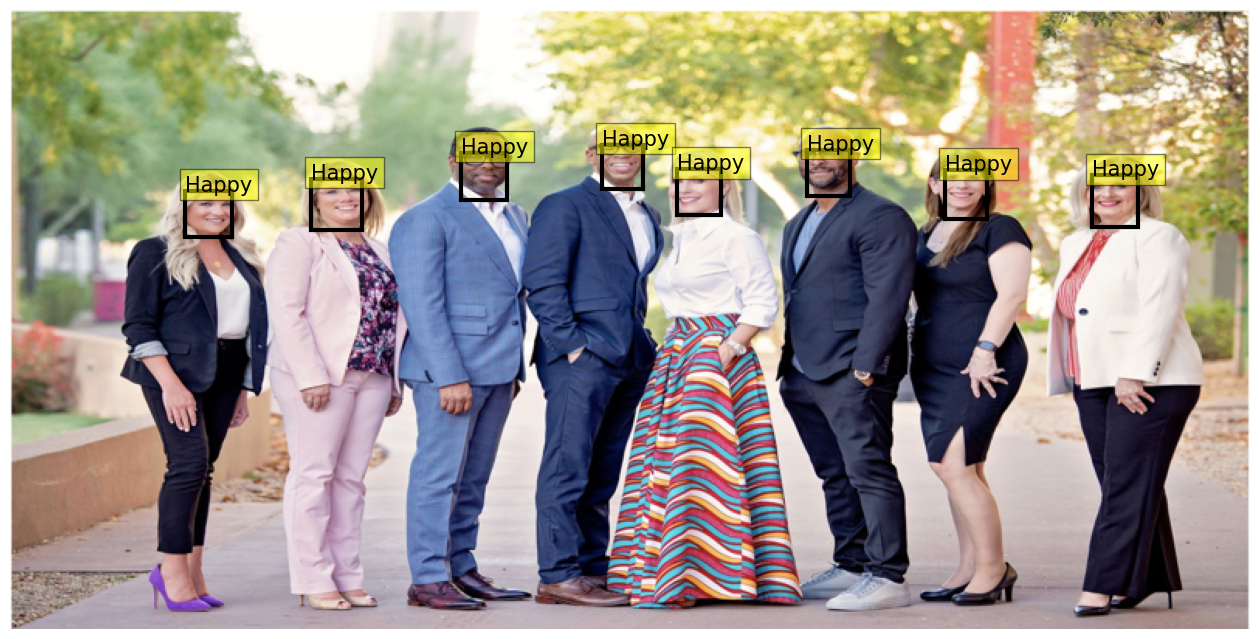

In [12]:
full_size_image = cv2.imread(path)
full_size_image = cv2.resize(full_size_image, (800, 400))
gray = cv2.cvtColor(full_size_image,cv2.COLOR_RGB2GRAY)

emotion = []

#detecting faces
for (x, y, xmax, ymax) in boxes:
        roi_gray = gray[int(y):int(ymax), int(x):int(xmax)]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)

        #predicting the emotion
        yhat= loaded_model.predict(cropped_img)
        emotion.append(labels[int(np.argmax(yhat))])

print(emotion)
plot_classes = ['person']
label_emotion(the_image, boxes.tolist(), emotion)